<a href="https://colab.research.google.com/github/threedee003/NotebooksForDL/blob/main/trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trainDir = "/content/drive/MyDrive/GIS/trainTiles"
testDir = "/content/drive/MyDrive/GIS/testTiles"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io as io
import time
from itertools import product



import torch.nn as nn
import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [4]:

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.imageFilenames = sorted(os.listdir(os.path.join(data_dir, "tiles")))

    def __len__(self):
        return len(self.imageFilenames)

    def __getitem__(self, idx):
        imagePath = os.path.join(self.data_dir, "tiles", self.imageFilenames[idx])
        img = np.load(imagePath)
        X = img[:,:,0:5]
        Y = img[:,:,-1]


        

        if self.transform:
            X = self.transform(X)
            Y = self.transform(Y)

        return X, Y


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
trainSet = CustomDataset(trainDir, transform=transform)
validationSet = CustomDataset(testDir, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=None, shuffle=True)
validationLoader = torch.utils.data.DataLoader(validationSet, batch_size = None, shuffle = True)

In [7]:
print("Number of training samples : {}".format(len(trainLoader)))
print("Number of validating samples : {}".format(len(validationLoader)))

Number of training samples : 1120
Number of validating samples : 440


In [8]:
class Autoencoder1(nn.Module):
  def __init__(self,channels):
    super(Autoencoder1,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(channels,64, kernel_size = 3),
        nn.Conv2d(64,64,kernel_size = 3, stride = 2),
        nn.Conv2d(64,128,kernel_size= 3),
        nn.Conv2d(128,128,kernel_size = 3,stride = 2),
        nn.Conv2d(128,256,kernel_size = 3),
        nn.Conv2d(256,256,kernel_size = 3,stride = 2),
        nn.Conv2d(256,512,kernel_size = 3)
    )

    self.decoder = nn.Sequential(
        nn.Conv2d(512,256,kernel_size = 2),
        nn.ConvTranspose2d(256,256,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(256,128,kernel_size = 3),
        nn.ConvTranspose2d(128,128,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(128,64,kernel_size = 3),
        nn.ConvTranspose2d(64,64,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(64,1,kernel_size = 3)
    )


  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [9]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
autoenc = Autoencoder2()

In [23]:

def trainer(model,trainLoader,validationLoader,epochs,lossFn,optimizer,trainLoss,validLoss,device,batchSize):
  print("Training has begun.....")
  startTime = time.time()
  model = model.to(device)
  for epoch in range(epochs):
    runningLoss = 0.0
    for x, y in trainLoader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = lossFn(pred,y)
      loss.backward()
      optimizer.step()
      runningLoss += loss.item()
    trainLoss.append(runningLoss/(len(trainLoader)/batchSize))

    with torch.no_grad():
      valLoss = 0.0
      for x, y in validationLoader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = lossFn(pred,y)
        valLoss += loss.item()
      validLoss.append(valLoss/(len(validationLoader)/batchSize))

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {runningLoss/len(trainLoader)}, Validation Loss: {valLoss/len(validationLoader)}")
  print(f"Training is complete......")
  print("--- %s seconds ---" % (time.time() - startTime))










      


In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoenc.parameters(), lr=0.001)
batchSize = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 50
trainArr = []
validArr = []

In [25]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [26]:
trainer(autoenc,trainLoader,validationLoader,eps,criterion,optimizer,trainArr,validArr,device,batchSize)

Training has begun.....
Epoch 1/50, Training Loss: 0.04760848573305501, Validation Loss: 0.03758712448943698
Epoch 2/50, Training Loss: 0.047886432026265476, Validation Loss: 0.03740189055295724
Epoch 3/50, Training Loss: 0.04625902117989621, Validation Loss: 0.03813280312950321
Epoch 4/50, Training Loss: 0.04683356750287788, Validation Loss: 0.037002628845882346
Epoch 5/50, Training Loss: 0.04723682207893327, Validation Loss: 0.037750471527545994
Epoch 6/50, Training Loss: 0.04597816863729674, Validation Loss: 0.037180080268647296
Epoch 7/50, Training Loss: 0.04635498380042041, Validation Loss: 0.03856046415682861
Epoch 8/50, Training Loss: 0.045863498829636945, Validation Loss: 0.04081068076772102
Epoch 9/50, Training Loss: 0.046136088272485914, Validation Loss: 0.039879199452248444
Epoch 10/50, Training Loss: 0.04651232638185547, Validation Loss: 0.03812941539225986
Epoch 11/50, Training Loss: 0.04627987652417898, Validation Loss: 0.037125717872417724
Epoch 12/50, Training Loss: 0.0

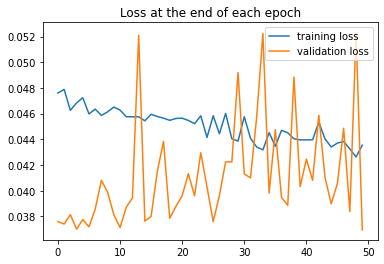

In [27]:
plt.plot(trainArr, label='training loss')
plt.plot(validArr, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();